In [1]:
import pandas as pd




In [12]:
data = pd.read_csv('data.csv')
data.head()

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,b69a8ad1a8280b8e6f0bd38b4cce8a4a,a8bd47b85e2b946052d816b208b3f0a4,2021-06-28 16:26:07,cb8cc7fef9d4410878603dad13f54cf5,ba11d753ac9444bc5f03fbd9fd98d923,594.445501,DEBITO
1,817d18cd3c31e40e9bff0566baae7758,650dcc8f0c905205f35b65d7ac5998b2,540c5783008d512771471e186f77d9be,2021-10-14 18:12:15,344adb90dd50281461e4429b69ce6eb3,4968649a6a6db0989e193923c1436c09,118.889100,DEBITO
2,817d18cd3c31e40e9bff0566baae7758,87be795748f41e4a4a97d783ce1f14cf,e3a9434b7e145d952d296cb255055b0f,2021-04-06 15:21:37,22cd1818eb77a5f0e25aacbfde8b24bf,15325b33069a73ac4ee0f6bf5e30d6fb,356.667301,DEBITO
3,838a8fa992a4aa2fb5a0cf8b15b63755,d99542642ab30f13a7676c46b423ea22,207693b4bb0a84615b2a4f002a483b0a,2021-08-16 14:59:33,ea9122c8693053dea289a414caab5521,96e95977ba74cd6a2d0cf76bb6a9b3b5,271.867272,CREDITO
4,817d18cd3c31e40e9bff0566baae7758,be7fd6155c65aeb95df167bf07dffd90,855e9baef9ba84ed74598c5a7de076d7,2021-09-17 20:39:45,22a07e37f9b02910126f702115884931,8b933efcc209a3269003ec7975b8a9a5,59.444550,DEBITO


In [43]:
# Convertir las fechas a formato datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y-%m-%d')

In [44]:
# Paso 1: Agrupar transacciones en ventanas de 24 horas por cuenta
windowed_data = data.groupby(['account_number', 'user_id']).apply(
    lambda group: group.sort_values('transaction_date')
).reset_index(drop=True)

C:\Users\yeiso\AppData\Local\Temp\ipykernel_12048\571115039.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  windowed_data = data.groupby(['account_number', 'user_id']).apply(


In [45]:
# Paso 2: Calcular métricas dentro de las ventanas de 24 horas
def detect_transaction_fraud(group):
    group = group.sort_values('transaction_date')
    group['time_diff'] = group['transaction_date'].diff().dt.total_seconds() / 3600  # Diferencia en horas

    # Identificar transacciones en la misma ventana de tiempo (24 horas)
    group['window_id'] = (group['time_diff'] > 24).cumsum()

    # Agrupar por ventana de tiempo
    summary = group.groupby('window_id').agg(
        total_amount=('transaction_amount', 'sum'),
        transaction_count=('transaction_amount', 'count')
    ).reset_index()

    # Identificar ventanas sospechosas
    summary['is_suspicious'] = (summary['transaction_count'] > 1) & (summary['total_amount'] > group['transaction_amount'].max())

    group = group.merge(summary[['window_id', 'is_suspicious']], on='window_id', how='left')
    return group

In [46]:
# Aplicar la función
processed_data = windowed_data.groupby('account_number').apply(detect_transaction_fraud).reset_index(drop=True)

C:\Users\yeiso\AppData\Local\Temp\ipykernel_12048\2896818477.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = windowed_data.groupby('account_number').apply(detect_transaction_fraud).reset_index(drop=True)


In [47]:
# Paso 3: Marcar transacciones sospechosas
processed_data['fraud_flag'] = processed_data['is_suspicious'].fillna(False).astype(int)

In [64]:
processed_data[processed_data['fraud_flag']>0].shape

(117, 12)

In [ ]:
# Paso 4: Guardar resultados
processed_data.to_csv('processed_data.csv', index=False)

In [63]:
processed_data.shape

(21516, 12)

In [ ]:
s, def

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
# Cargar datos
df = data

# Convertir la columna transaction_date a datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])


# Eliminar duplicados, si los hay
df = df.drop_duplicates()


                              merchant_id                               _id  \
1081054  075d178871d8d48502bf1f54887e52fe  b69a8ad1a8280b8e6f0bd38b4cce8a4a   
2471502  817d18cd3c31e40e9bff0566baae7758  650dcc8f0c905205f35b65d7ac5998b2   
6868479  817d18cd3c31e40e9bff0566baae7758  87be795748f41e4a4a97d783ce1f14cf   
9424293  838a8fa992a4aa2fb5a0cf8b15b63755  d99542642ab30f13a7676c46b423ea22   
6613222  817d18cd3c31e40e9bff0566baae7758  be7fd6155c65aeb95df167bf07dffd90   

                               subsidiary    transaction_date  \
1081054  a8bd47b85e2b946052d816b208b3f0a4 2021-06-28 16:26:07   
2471502  540c5783008d512771471e186f77d9be 2021-10-14 18:12:15   
6868479  e3a9434b7e145d952d296cb255055b0f 2021-04-06 15:21:37   
9424293  207693b4bb0a84615b2a4f002a483b0a 2021-08-16 14:59:33   
6613222  855e9baef9ba84ed74598c5a7de076d7 2021-09-17 20:39:45   

                           account_number                           user_id  \
1081054  cb8cc7fef9d4410878603dad13f54cf5  ba11d753ac94

In [57]:
# Crear una columna para agrupar por cuenta y fecha
df['date_only'] = df['transaction_date'].dt.date

# Convertir los montos de transacciones a float 
df['transaction_amount'] = df['transaction_amount'].astype(float)

# Agrupar por account_number y date_only, sumar transaction_amount
agg_df = df.groupby(['account_number', 'date_only']).agg({
    'transaction_amount': 'sum',
    'transaction_date': 'count'}).reset_index()

agg_df.columns = ['account_number', 'date_only', 'total_transaction_amount', 'transaction_count']

agg_df.head()


,account_number,date_only,total_transaction_amount,transaction_count
0,00010676f0dd636b3048712e88b46fe5,2021-07-17,332.889481,1
1,0001ecdff5702d9d03767b74069587c9,2021-02-06,166.444740,1
2,00074948864d50206de2ac84c8edb5af,2021-11-28,356.667301,1
3,000b778c0382b8ef2d0650bce981a610,2021-09-08,142.666920,1
4,000d762637197034a5661929579bedac,2021-11-09,475.556401,1


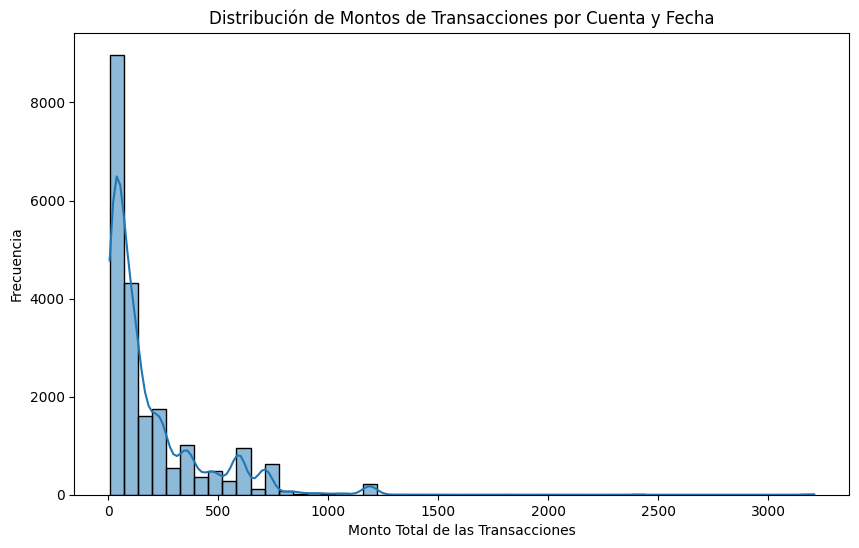

Media: 191.56214269075568
Desviación Estándar: 242.55899421328505


In [58]:
# Visualizar la distribución de los montos de transacciones
plt.figure(figsize=(10, 6))
sns.histplot(agg_df['total_transaction_amount'], bins=50, kde=True)
plt.title('Distribución de Montos de Transacciones por Cuenta y Fecha')
plt.xlabel('Monto Total de las Transacciones')
plt.ylabel('Frecuencia')
plt.show()

# Calcular estadísticas
mean_amount = agg_df['total_transaction_amount'].mean()
std_amount = agg_df['total_transaction_amount'].std()

print(f"Media: {mean_amount}")
print(f"Desviación Estándar: {std_amount}")


In [60]:
# Definir el umbral como 3 desviaciones estándar por encima de la media
threshold = mean_amount + 3 * std_amount

# Identificar comportamientos sospechosos
agg_df['suspicious'] = agg_df['total_transaction_amount'] > threshold

# Filtrar transacciones sospechosas
suspicious_transactions = agg_df[agg_df['suspicious'] == True]

suspicious_transactions.head()

,account_number,date_only,total_transaction_amount,transaction_count,suspicious
178,0230d3c7ffe956fbe8e5eaca27e9f85d,2021-04-30,1188.891002,1,True
203,02877f80702f0856bc682440e039b7bc,2021-09-11,1188.891002,1,True
270,035a402900a19897a8b87db2723ee15a,2021-08-21,951.112802,1,True
291,039e81dc62b547da63e0e928573effd3,2021-08-31,1188.891002,1,True
524,06b271c09a5ec83cc4e452bbb29f9c18,2021-06-26,1188.891002,1,True


In [62]:
suspicious_transactions.shape

(346, 5)

In [65]:
# Resumir el dataset 
df.info() 
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 21516 entries, 1081054 to 2879815
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   merchant_id         21516 non-null  object        
 1   _id                 21516 non-null  object        
 2   subsidiary          21516 non-null  object        
 3   transaction_date    21516 non-null  datetime64[ns]
 4   account_number      21516 non-null  object        
 5   user_id             21516 non-null  object        
 6   transaction_amount  21516 non-null  float64       
 7   transaction_type    21516 non-null  object        
 8   group_id            21516 non-null  object        
 9   date_only           21516 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.8+ MB


,transaction_date,transaction_amount
count,21516,21516.000000
mean,2021-06-25 11:41:13.779140864,191.223820
min,2021-01-01 09:34:40,5.944455
25%,2021-03-27 18:56:21.750000128,35.666730
50%,2021-07-02 15:26:47.500000,107.000190
75%,2021-09-21 16:50:02.500000,237.778200
max,2021-11-30 23:04:10,3210.005707
std,NaN,242.352323


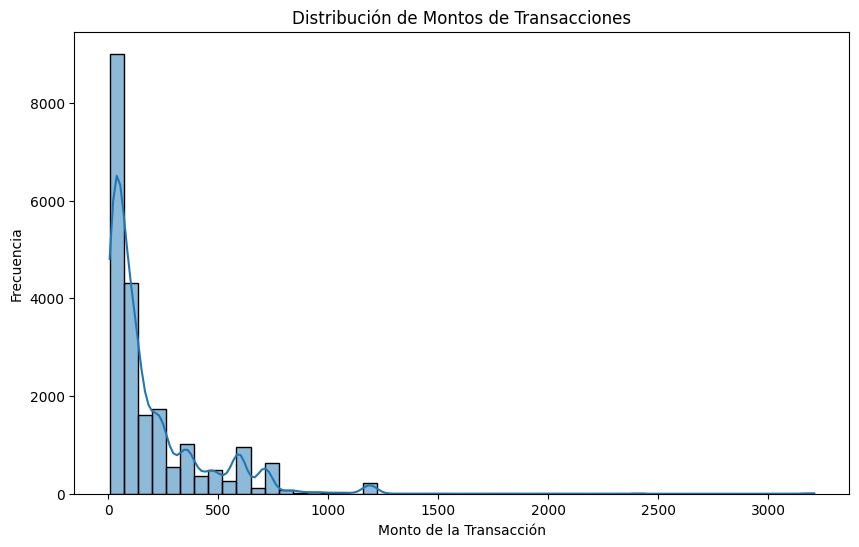

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title('Distribución de Montos de Transacciones')
plt.xlabel('Monto de la Transacción')
plt.ylabel('Frecuencia')
plt.show()


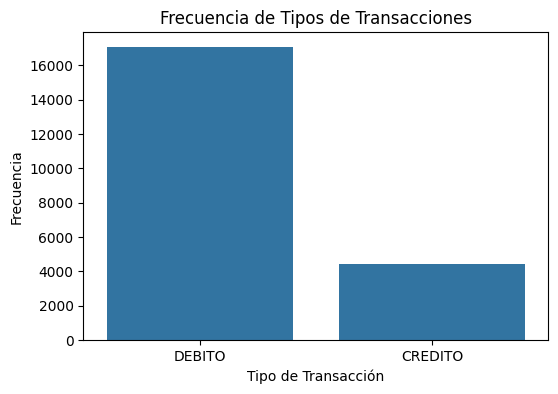

In [67]:
plt.figure(figsize=(6, 4))
sns.countplot(x='transaction_type', data=df)
plt.title('Frecuencia de Tipos de Transacciones')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Frecuencia')
plt.show()


In [69]:
from sklearn.ensemble import IsolationForest

# Entrenar un modelo de Isolation Forest
model = IsolationForest(contamination=0.01)  # ajusta 'contamination' basado en el porcentaje de transacciones esperadas como anómalas
df['amount_log'] = np.log1p(df['transaction_amount'])  # Aplicar log para manejar sesgos en los datos
model.fit(df[['amount_log']])

# Predecir transacciones anómalas
df['anomaly'] = model.predict(df[['amount_log']])  # 1: normal, -1: anómalas

# Filtrar las transacciones anómalas
suspicious_transactions = df[df['anomaly'] == -1]
suspicious_transactions.head()


,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,group_id,date_only,amount_log,anomaly
8209329,817d18cd3c31e40e9bff0566baae7758,5befbdbaed35bca999111d78aa740191,7a31293cbe453c3f2b84cf3f80587356,2021-11-29 14:47:18,3a116edc8af9987f7515d140b6a49e5e,24f41cf21f5363c23adb053e12c4872b,3210.005707,DEBITO,24f41cf21f5363c23adb053e12c4872b,2021-11-29,8.074339,-1
1652327,817d18cd3c31e40e9bff0566baae7758,e90f0688af19f4bdcd80ec14ba636d43,448b8cc741cb2d77aaa7f6fd0e34bd43,2021-08-27 15:19:20,8a9594c3441e4ea2ccf06089fa4a907b,506eb9dfb20b36eb0e7fa6478f823bc0,2092.448164,DEBITO,506eb9dfb20b36eb0e7fa6478f823bc0,2021-08-27,7.646568,-1
8007126,817d18cd3c31e40e9bff0566baae7758,789e853fa2edb1f5b84deee0d34d942b,f17b022ad5fb2f6875611d94fb2e92ed,2021-11-05 16:34:52,3b8dbb00a82076e63dbd3184a911fa0b,af02082eb7246844b1ae5028b4bf2589,2211.337265,DEBITO,af02082eb7246844b1ae5028b4bf2589,2021-11-05,7.701805,-1
3009323,817d18cd3c31e40e9bff0566baae7758,aaa89d835e5060c8395c44917db7ceeb,fbb39eb74e2b7ea252a45bd034c55021,2021-08-03 18:00:24,3113930b312c694f12b17dcd78be6b3c,60757c3109b3b234791cca6b1770e53e,1426.669203,DEBITO,60757c3109b3b234791cca6b1770e53e,2021-08-03,7.263798,-1
6143937,817d18cd3c31e40e9bff0566baae7758,1d12e6719ba719061f27dff887a39440,385110367dca4a60adee7995feeb76f0,2021-09-16 07:36:11,38fd65ee7587803952c62586597f62a5,e32c378aca2a25cb1e1d31a5f49c0bc5,2258.892905,DEBITO,e32c378aca2a25cb1e1d31a5f49c0bc5,2021-09-16,7.723073,-1


In [71]:
suspicious_transactions.shape

(52, 12)